We import the necessary libraries for building and training an object detection model using PyTorch and Torchvision. It includes essential libraries such as torch for tensor operations, numpy for numerical computations, and matplotlib for visualizations. It also imports specific functions and modules from Torchvision, like to_pil_image for image transformations and FastRCNNPredictor for modifying the Faster R-CNN model.

In [51]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms.functional import to_tensor

We then  extends the CocoDetection dataset from Torchvision to create a custom dataset for object detection tasks. The __init__ method initializes the dataset with a root directory, annotation file, and optional transformations. The __getitem__ method retrieves an image and its annotations by index, processes the annotations to format bounding boxes and labels, and applies any specified transformations to the image. The _process_target method formats the bounding boxes and labels as tensors,the custom COCO dataset for training and validation, specifying the paths to the dataset directories and annotation files. The DataLoader objects for both datasets are then created with a batch size of 32. The collate_fn argument is used to handle batches of data by zipping the images and targets together.

In [52]:
class CustomCocoDataset(CocoDetection):
    def __init__(self, root, annFile, transform=None):
        super(CustomCocoDataset, self).__init__(root, annFile)
        self.transform = transform
    def __getitem__(self, index):
        img, target = super(CustomCocoDataset, self).__getitem__(index)
        target = self._process_target(target)
        if self.transform is not None:
            img = self.transform(img)
        return img, target
    def _process_target(self, target):
        boxes = [obj["bbox"] for obj in target]
        labels = [obj["category_id"] for obj in target]
        boxes = [[x, y, x + w, y + h] for x, y, w, h in boxes]
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        return {"boxes": boxes, "labels": labels}
train_dataset = CustomCocoDataset(root='/content/drive/MyDrive/ssdtrainingnew',
                                   annFile='/content/_annotationstrain.coco.json',
                                   transform=ToTensor())
val_dataset = CustomCocoDataset(root='/content/drive/MyDrive/ssdvalid',
                                 annFile='/content/_annotations13.coco.json',
                                 transform=ToTensor())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


The training loop for the object detection model. It starts by importing the necessary modules and setting the device to GPU if available. The model is defined with get_object_detection_model, and the optimizer is initialized using stochastic gradient descent (SGD). The training loop runs for a specified number of epochs, processing each batch of images and targets, computing the loss, performing backpropagation, and updating the model parameters. After each epoch, it prints the average loss.

In [53]:
import torch
import torch.optim as optim
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2
model = get_object_detection_model(num_classes)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        if isinstance(targets, tuple):
            targets = list(targets)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        running_loss += losses.item()
    print(f"Epoch {epoch}: Loss: {running_loss / len(train_loader)}")
print("Training completed")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0: Loss: 0.8916795253753662
Epoch 1: Loss: 0.3141697645187378
Epoch 2: Loss: 0.24010512232780457
Epoch 3: Loss: 0.2962111830711365
Epoch 4: Loss: 0.3082104027271271
Epoch 5: Loss: 0.36726218461990356
Epoch 6: Loss: 0.36315035820007324
Epoch 7: Loss: 0.3572520613670349
Epoch 8: Loss: 0.3184630274772644
Epoch 9: Loss: 0.2813504636287689
Training completed


We save the trained model's state dictionary to a file named trained_model.pth. This allows the model to be reloaded and used later without retraining.

In [54]:
model_save_path = 'trained_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to trained_model.pth


We defines a function get_object_detection_model that loads a pre-trained Faster R-CNN model and modifies it to match the specified number of classes. The model is then instantiated and loaded with previously saved weights. If there is an error in loading the model, it is caught and printed. Finally, the model is moved to the appropriate device and set to evaluation mode

In [55]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def get_object_detection_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model
num_classes = 2
model = get_object_detection_model(num_classes)
try:
    model.load_state_dict(torch.load('/content/trained_model.pth'), strict=False)
except RuntimeError as e:
    print(f"Error loading model: {e}")
model.to(device)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

The  function draw_boxes takes an image, bounding boxes, and labels, and optionally colors as inputs. It converts the image to a PIL image if it's a tensor and ensures it is in the correct format. It then plots the image using matplotlib and draws the bounding boxes with specified colors. The labels are annotated above each box.

In [56]:
def draw_boxes(image, boxes, labels, colors=None):
    if isinstance(image, torch.Tensor):
        image = to_pil_image(image.squeeze(0))
    elif isinstance(image, np.ndarray):
        image = image
    else:
        raise TypeError(f"Unsupported image type: {type(image)}")
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)
    if colors is not None:
        num_colors = len(colors)
        if not all(0 <= label < num_colors for label in labels):
            raise ValueError("Labels exceed the number of colors provided.")
    for box, label in zip(boxes, labels):
        if colors is not None:
            color = colors[label]
        else:
            color = 'red'
        rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                             fill=False, edgecolor=color, linewidth=3)
        ax.add_patch(rect)
        ax.text(box[0], box[1] - 10, f'Label {label}', color=color, fontsize=12,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.show()

The visualize_prediction takes a trained model, dataset, and an index as inputs to visualize the model's predictions. It sets the model to evaluation mode and processes the image without computing gradients. The image and corresponding outputs are passed to the draw_boxes function to visualize the predicted bounding boxes and labels. The function is then called with the validation dataset to visualize predictions for a specific index

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Predicted boxes: [[254.11722   37.06418  373.14587  196.812   ]
 [227.75613   15.432471 377.1749   404.1835  ]
 [274.81076   36.65933  398.84982  291.52313 ]
 [286.27298   55.695187 396.74646  174.73917 ]
 [282.37823   25.05168  390.8984   130.7898  ]
 [257.87268   50.693848 336.14203  287.14084 ]
 [208.41443  102.76296  362.31     574.44006 ]
 [225.54297   36.193295 340.37363  155.39526 ]
 [287.3017    55.37991  376.91135  480.4461  ]
 [271.12085   97.11065  381.5233   226.2349  ]]
Predicted labels: [1 1 1 1 1 1 1 1 1 1]


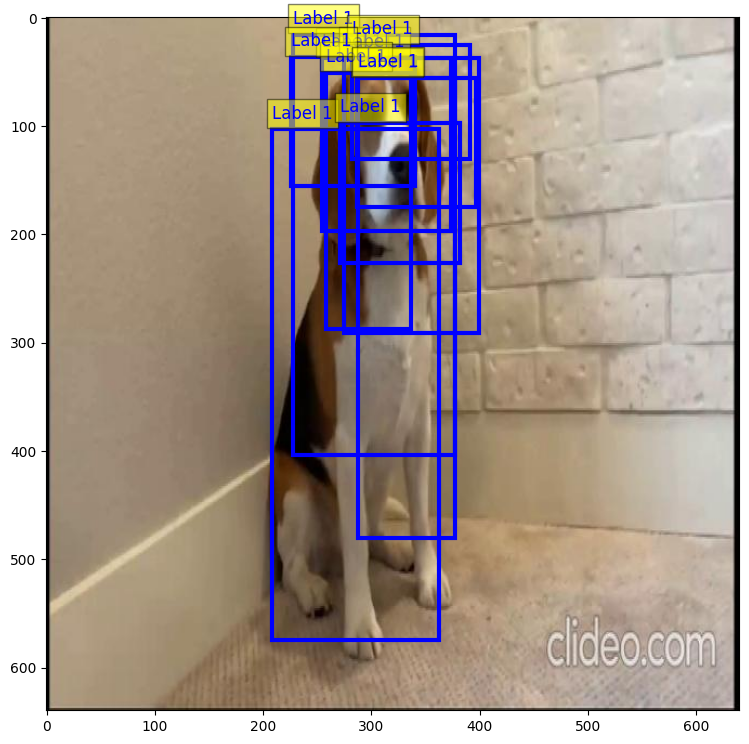

In [57]:
def visualize_prediction(model, dataset, index=0, device='cpu'):
    model.eval()
    with torch.no_grad():
        image, _ = dataset[index]
        image_tensor = image.unsqueeze(0).to(device)
        outputs = model(image_tensor)[0]
        pred_boxes = outputs['boxes'].cpu().numpy()
        pred_labels = outputs['labels'].cpu().numpy()
        print(f"Predicted boxes: {pred_boxes}")
        print(f"Predicted labels: {pred_labels}")
        draw_boxes(image, pred_boxes, pred_labels, colors=['red', 'blue'])
val_dataset = CustomCocoDataset(root='/content/drive/MyDrive/ssdvalid',
                                annFile='/content/_annotations13.coco.json',
                                transform=ToTensor())

visualize_prediction(model, val_dataset, index=0, device=device)